<a href="https://colab.research.google.com/github/surya3001/NNDL-Project/blob/main/Space_invaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space Invaders Game using Categorical Deep Q network

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install PILLOW
!pip install gym
!pip install gym[atari,accept-rom-license]==0.21.0
!pip install --upgrade tensorflow-probability

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver,dynamic_step_driver
from tf_agents.environments import suite_gym,suite_atari
from tf_agents.environments import tf_py_environment,batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential,q_network, network ,categorical_q_network
from tf_agents.policies import py_tf_eager_policy,random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer,tf_uniform_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.trajectories import time_step as ts
from tf_agents.networks.q_network import QNetwork
from tf_agents.environments.tf_py_environment import TFPyEnvironment

# Set up a virtual display for rendering OpenAI gym environments.

In [ ]:
#Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
tf.version.VERSION

'2.8.0'

# Defining the Parameters

In [ ]:
num_iterations = 20000 # @param {type:"integer"} # number of epochs

initial_collect_steps =   400# @param {type:"integer"}
collect_steps_per_iteration =   10# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}# size of replay buffer

batch_size = 64  # @param {type:"integer"}
learning_rate = 2.5e-3  # @param {type:"number"} # for optimizers
log_interval =   5000# @param {type:"integer"}

num_eval_episodes =   5# @param {type:"integer"} # number of levels in a game
eval_interval =   25000# @param {type:"integer"} # number of steps in each game

# Loading the Environment

In [ ]:
env_name = 'SpaceInvaders-v0'
ATARI_FRAME_SKIP = 4
max_episode_frames=108000
# this function is used to reduce the frames of the game and load the environment
env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING) 

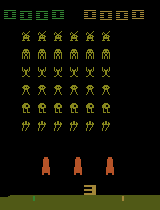

In [ ]:
# sample of dataset
env.reset()
PIL.Image.fromarray(env.render())

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation) # printing the shape of the input

Observation Spec:
BoundedArraySpec(shape=(84, 84, 4), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)


In [ ]:
env.observation_space # Representing dataset as array

Box([[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]], [[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 25

In [ ]:
env.action_space # Number of actions in game

Discrete(6)

# Training and testing split

In [ ]:
train_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING) # we do preprocessing on training set

eval_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

In [ ]:
# converting the environment to tensor environment
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Preprocessing Layer

In [ ]:
preprocessing_layer = tf.keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.)

# Defining the architecture of the model 

In [ ]:
conv_layer_params=((32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)) # 3 Conv2d layers with 32 filter layer, 8 kernel size and 4 strides 
fc_layer_params=(512,) # Dense layer of 512 neurons

q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    num_atoms=51,
    fc_layer_params=fc_layer_params,activation_fn=tf.keras.activations.relu) # we use relu as activation function

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(
    learning_rate=learning_rate)
# We use adam optimizer here
train_step_counter = tf.Variable(0) # counting the number of training steps we assign a variable

observation_spec = tensor_spec.from_spec(train_env.observation_spec())
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.from_spec(train_env.action_spec())

target_update_period=32000  # ALE frames
update_period=16  # ALE frames
_update_period = update_period / ATARI_FRAME_SKIP # 

'''epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, 
    decay_steps=150000 // update_period, 
    end_learning_rate=0.01)''' 

agent = categorical_dqn_agent.CategoricalDqnAgent(
    time_step_spec, # input layer
    action_spec, # action layer
    categorical_q_network=q_net, # Here we load the CNN model
    optimizer=optimizer,
    #epsilon_greedy=lambda: epsilon_fn(train_step_counter),
    n_step_update=1.0,
    target_update_tau=1.0,
    target_update_period=(
        target_update_period / ATARI_FRAME_SKIP / _update_period),
    gamma=0.99,
    reward_scale_factor=1.0,
    debug_summaries=True,
    summarize_grads_and_vars=False)
agent.initialize() # initialize the agent

In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

# Metrics and Evaluation

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)

94.0

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)


  replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)


dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# Train the dataset

In [ ]:
# Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
    returns.append(avg_return)

step = 5000: loss = 3.674888849258423
step = 10000: loss = 3.4261422157287598
step = 15000: loss = 3.2745537757873535
step = 20000: loss = 3.2656893730163574


(8.505, 550.0)

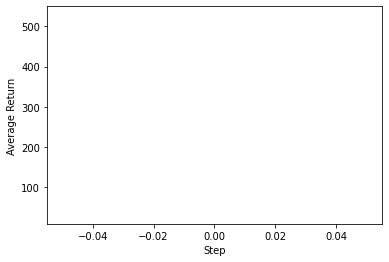

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

# Gameplay Before Training

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [ ]:
create_policy_eval_video(random_policy, "random-agent")

# Trained Gameplay

In [ ]:
num_episodes = 10
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)